#### Question: Are there any specific services or products that are more commonly associated with each reason category for churn?

##### Expectations:
analyzing the specific services or products that are commonly associated with each reason category for churn can provide valuable insights for the business. For example, if customers are churning due to issues with internet speed, the company may need to invest in improving their network infrastructure. If customers are churning due to high prices, the company may need to consider adjusting their pricing strategy or offering more affordable packages. By understanding the specific services or products that are driving customer churn, the company can make targeted improvements to reduce churn rates and improve customer satisfaction. Additionally, this information can inform the development of new products or services that better meet the needs and preferences of customers.

#### EDA:

In [108]:
# Importing the libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
# Load the data from /Dataset/Telco_customer_churn_services.xlsx
dataset1 = pd.read_excel('../Dataset/Telco_customer_churn_services.xlsx')

In [89]:
dataset1.columns

Index(['Customer ID', 'Count', 'Quarter', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue'],
      dtype='object')

In [90]:
my_columns = ['Customer ID', 'Phone Service', 'Internet Service', 'Multiple Lines',
              'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data']

dataset1 = dataset1[my_columns]


In [91]:
# we need the churn category from a different file
dataset2 = pd.read_excel('../Dataset/Telco_customer_churn_status.xlsx')

In [92]:
dataset2.columns

Index(['Customer ID', 'Count', 'Quarter', 'Satisfaction Score',
       'Customer Status', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV',
       'Churn Category', 'Churn Reason'],
      dtype='object')

In [93]:
my_columns = ['Customer ID', 'Churn Category','Churn Label']

dataset2 = dataset2[my_columns]

In [94]:
# merge the two datasets
dataset = pd.merge(dataset1, dataset2, on='Customer ID')

In [95]:
dataset.columns

Index(['Customer ID', 'Phone Service', 'Internet Service', 'Multiple Lines',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Unlimited Data', 'Churn Category',
       'Churn Label'],
      dtype='object')

In [96]:
# Check for messing values
dataset.isnull().sum()

Customer ID                  0
Phone Service                0
Internet Service             0
Multiple Lines               0
Online Security              0
Online Backup                0
Device Protection Plan       0
Premium Tech Support         0
Unlimited Data               0
Churn Category            5174
Churn Label                  0
dtype: int64

We see that churn category is missing some values but we are not sure yet if that is a problem or it is just because the customer did not churn. We will check that.

In [97]:
# make sure that when churn category is missing the churn label is false
dataset[dataset['Churn Category'].isnull()]['Churn Label'].value_counts()

No    5174
Name: Churn Label, dtype: int64

it is indeed the case that the missing values in the churn category are due to the fact that the customer did not churn. We will drop all customers who have not churned because we are only interested in the customers who have churned.

In [98]:
# drop customers who have not churned
dataset = dataset[dataset['Churn Category'].notnull()]

In [99]:
dataset.isnull().sum()

Customer ID               0
Phone Service             0
Internet Service          0
Multiple Lines            0
Online Security           0
Online Backup             0
Device Protection Plan    0
Premium Tech Support      0
Unlimited Data            0
Churn Category            0
Churn Label               0
dtype: int64

In [100]:
# drop the customer ID column
if 'Customer ID' in dataset.columns:
    dataset.drop({'Customer ID','Churn Label'}, axis=1, inplace=True)

In [101]:
dataset.dtypes

Phone Service             object
Internet Service          object
Multiple Lines            object
Online Security           object
Online Backup             object
Device Protection Plan    object
Premium Tech Support      object
Unlimited Data            object
Churn Category            object
dtype: object

In [102]:
# clone the dataset
datasetDummies = dataset.copy()
# turn the categorical variables into dummy variables except for the churn category 
dataset = pd.get_dummies(dataset.drop(
    'Churn Category', axis=1), drop_first=True)

# add the churn category to the dataset
dataset['Churn Category'] = datasetDummies['Churn Category']

# check the data types of the columns
dataset.dtypes


Phone Service_Yes              uint8
Internet Service_Yes           uint8
Multiple Lines_Yes             uint8
Online Security_Yes            uint8
Online Backup_Yes              uint8
Device Protection Plan_Yes     uint8
Premium Tech Support_Yes       uint8
Unlimited Data_Yes             uint8
Churn Category                object
dtype: object

In [103]:
dataset.columns

Index(['Phone Service_Yes', 'Internet Service_Yes', 'Multiple Lines_Yes',
       'Online Security_Yes', 'Online Backup_Yes',
       'Device Protection Plan_Yes', 'Premium Tech Support_Yes',
       'Unlimited Data_Yes', 'Churn Category'],
      dtype='object')

In [104]:
# rename the columns with _Yes to remove the _Yes
if 'Phone Service_Yes' in dataset.columns:
    dataset.rename(columns={'Phone Service_Yes': 'Phone Service',
                            'Internet Service_Yes': 'Internet Service',
                            'Multiple Lines_Yes': 'Multiple Lines',
                            'Online Security_Yes': 'Online Security',
                            'Online Backup_Yes': 'Online Backup',
                            'Device Protection Plan_Yes': 'Device Protection Plan',
                            'Premium Tech Support_Yes': 'Premium Tech Support',
                            'Unlimited Data_Yes': 'Unlimited Data'}, inplace=True)

In [105]:
dataset.head()

,Phone Service,Internet Service,Multiple Lines,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Unlimited Data,Churn Category
0,0,1,0,0,0,1,0,0,Competitor
1,1,1,1,0,1,0,0,1,Competitor
2,1,1,1,0,0,0,0,1,Competitor
3,1,1,0,0,1,1,0,1,Dissatisfaction
4,1,1,1,0,0,0,0,1,Price


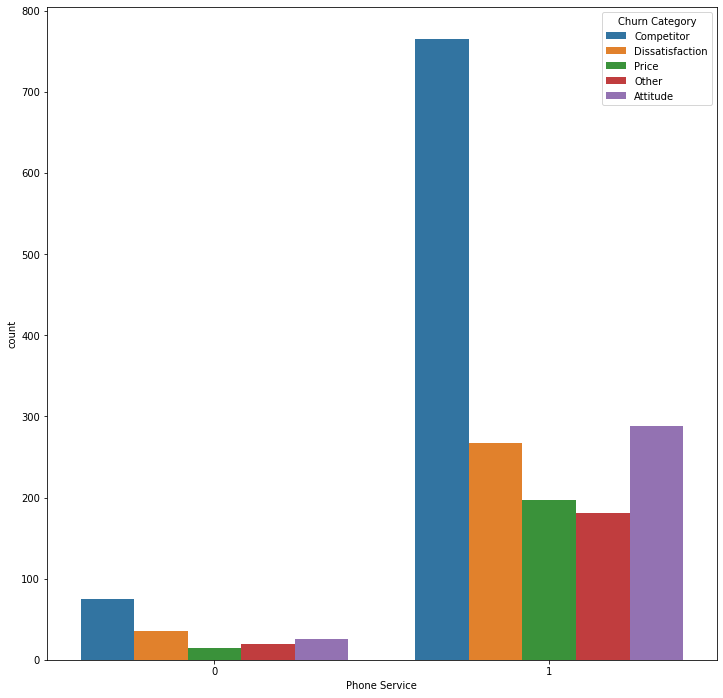

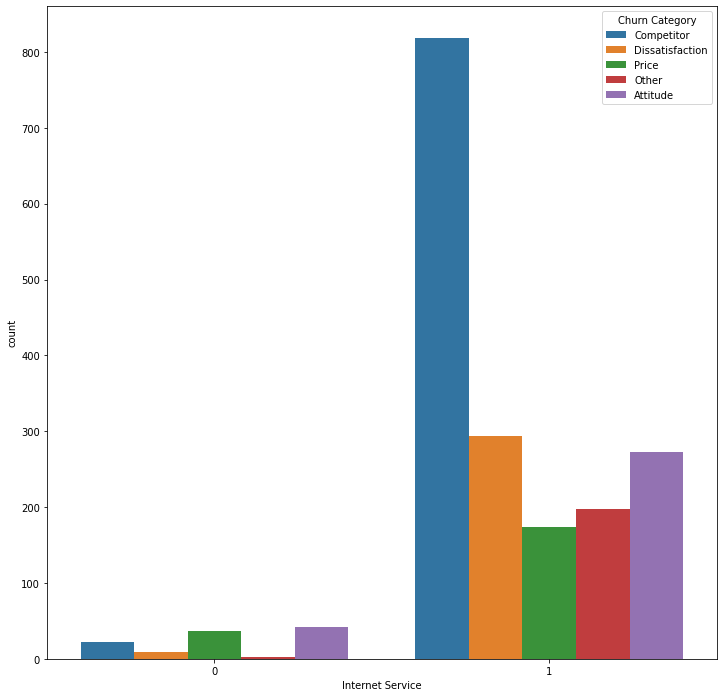

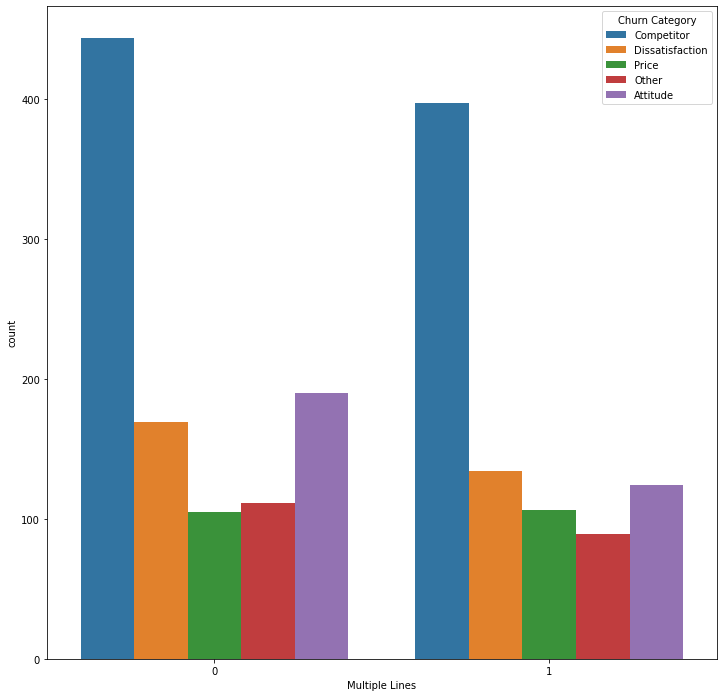

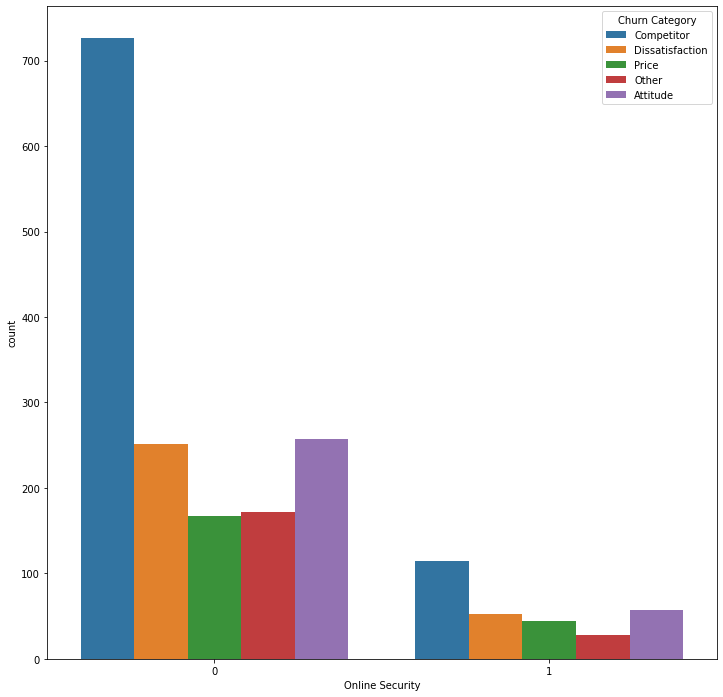

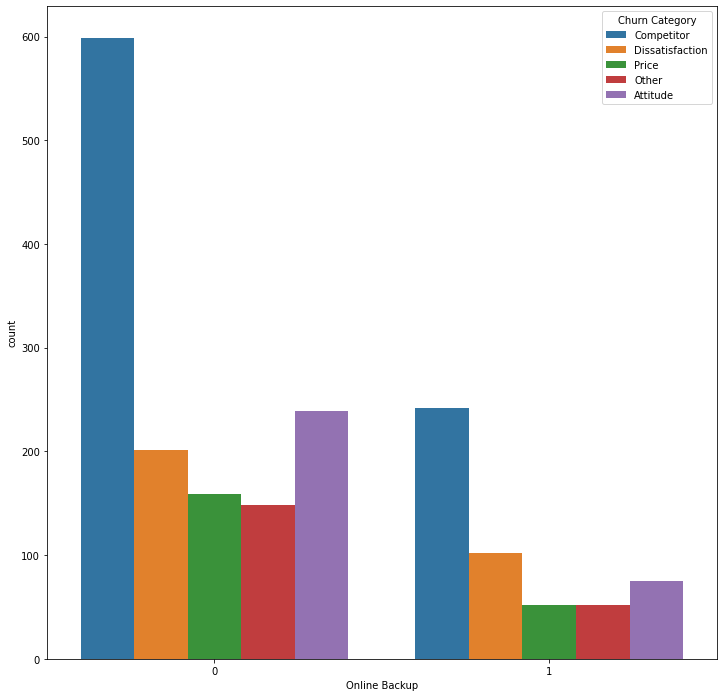

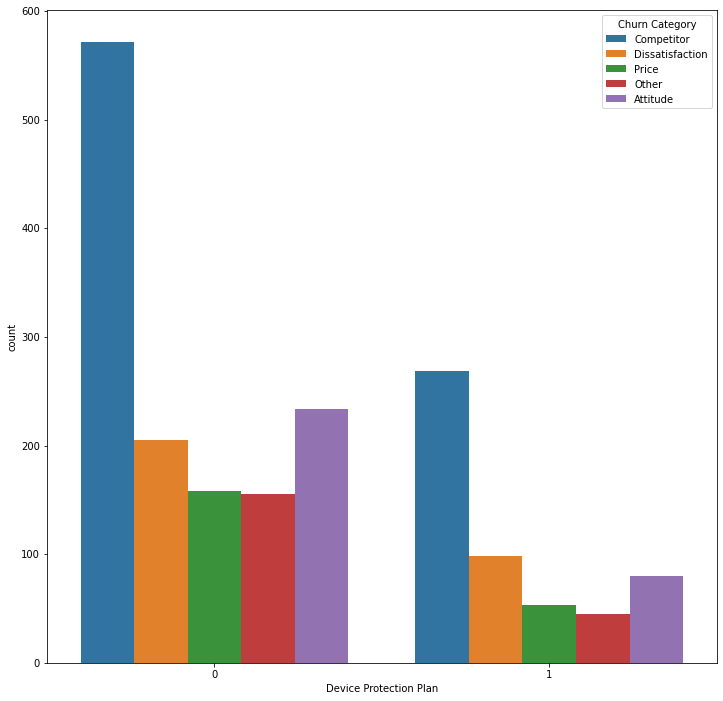

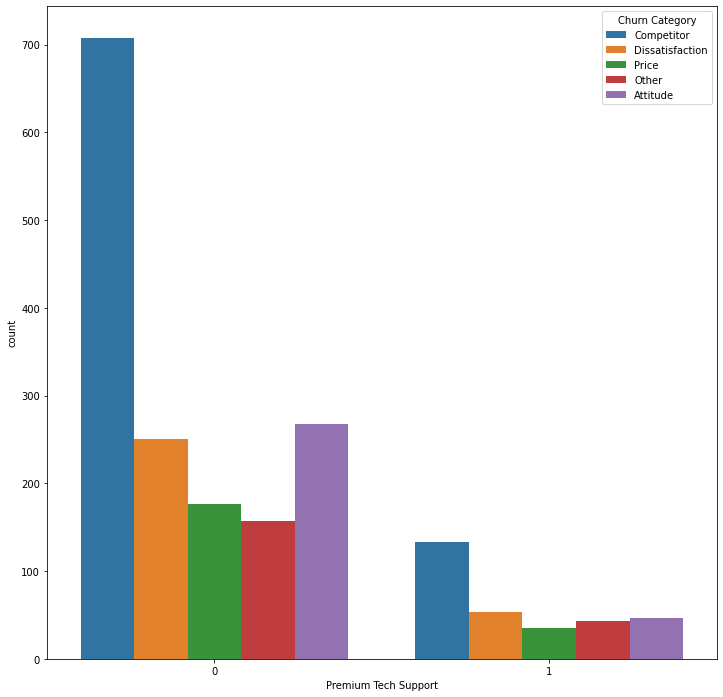

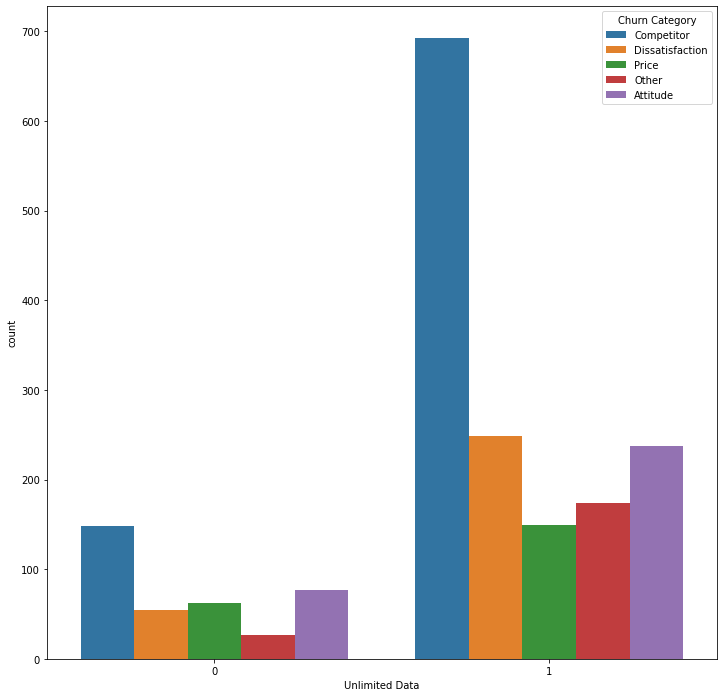

In [114]:
# visualize the distribution of the different services and the churn categories
plt.figure(figsize=(12, 12))
sns.countplot(x='Phone Service', hue='Churn Category', data=dataset)
plt.show()

plt.figure(figsize=(12, 12))
sns.countplot(x='Internet Service', hue='Churn Category', data=dataset)
plt.show()

plt.figure(figsize=(12, 12))
sns.countplot(x='Multiple Lines', hue='Churn Category', data=dataset)
plt.show()

plt.figure(figsize=(12, 12))
sns.countplot(x='Online Security', hue='Churn Category', data=dataset)
plt.show()

plt.figure(figsize=(12, 12))
sns.countplot(x='Online Backup', hue='Churn Category', data=dataset)
plt.show()

plt.figure(figsize=(12, 12))
sns.countplot(x='Device Protection Plan', hue='Churn Category', data=dataset)
plt.show()

plt.figure(figsize=(12, 12))
sns.countplot(x='Premium Tech Support', hue='Churn Category', data=dataset)
plt.show()

plt.figure(figsize=(12, 12))
sns.countplot(x='Unlimited Data', hue='Churn Category', data=dataset)
plt.show()

In [ ]:
#TODO: check the correlation between the different services and the churn category